# BASIC CONFIGURATIONS

In [1]:
### Setup the library ###
import pyrogue as pr
import os, sys
import matplotlib.pyplot as plt
import time
import datetime
import numpy as np
import math
import pprint
import inspect 
top_level=f'{os.getcwd()}/../'
rootTopLevel = top_level+'script/'
pr.addLibraryPath( rootTopLevel )

import setupLibPaths

import ePix320kM as devBoard

args = None

In [2]:
# ONLY RUN ONCE!
# Defining root
# If crashes, make sure the deve is correct.
root =  devBoard.Root(   
        top_level  = top_level,
        dev        = '/dev/datadev_1',
        pollEn     = False,
        initRead   = True,
        pciePgpEn  = True,
        justCtrl   = False,
        DDebugSize = 4000)
root.start()

# example showing a read
AxiVersion = root.Core.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

GeneralError: AxiStreamDma::AxiStreamDma: General Error: Failed to open device file /dev/datadev_1 with dest 0x0! Another process may already have it open!

In [3]:
#Run this from a teminal in your localhost without the (!). If you run it here, it will open on rdsrv314 Jupyter server terminal and you won't see it.
#!python -m pyrogue gui --server='localhost:9099'

In [4]:
# Configure clock to 168 MHz and configures all ASICS
root.InitASIC([4,1,0,1,0])

Rysync ASIC started
Did not find specific ASIC1 file. Using generic.
Did not find specific ASIC2 file. Using generic.
Did not find specific ASIC3 file. Using generic.
Did not find specific ASIC4 file. Using generic.
Init ASIC script started
Loading PLL configuration
Loading supply configuration
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/..//config/ePixHRM320k_PowerSupply_Enable.yml
Loading lane delay configurations
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/..//config/ePixHRM320k_cb000018f0322301_SspMonGrp_carrier.yml
Loading waveforms configuration
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/..//config/ePixHRM320k_RegisterControl.yml
Loading batcher configurations
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/..//config/ePixHRM32

In [5]:
run helperFunctions.ipynb

# Disable full rate receivers for now

In [6]:
disableAllReceivers()

# Single image acquire example

In [7]:
root.getLaneLocks()

ASIC0: 0xffffff
ASIC1: 0x0
ASIC2: 0x3effff
ASIC3: 0x0


In [8]:
printLaneMask()

ASIC0: 0x0
ASIC1: 0x0
ASIC2: 0xc10000
ASIC3: 0x0


In [9]:
#Enable data receivers and run some triggers
root.enableDataRcv(True)
root.enableAllAsics(True)
root.Trigger()

ASIC:1 F#:72510 Mask:0xffffff
ASIC:0 F#:72510 Mask:0x110100
ASIC:3 F#:72510 Mask:0xffffff
ASIC:2 F#:72510 Mask:0xc10000


In [10]:
# Obtain descrambled single frame data from ASICs from DataReceiver. Data receiver is down sampled.
root.printDataReceiverStatus()
    
frame = [None for i in range(4)]
for asicIndex in range(4):
    frame[asicIndex] = getattr(root, f"DataReceiver{asicIndex}").Data.get()

Checkpoint: DataReceiver 0 has 1 frames
Checkpoint: DataReceiver 1 has 1 frames
Checkpoint: DataReceiver 2 has 1 frames
Checkpoint: DataReceiver 3 has 1 frames


In [11]:
#frame dimensions
for asicIndex in range(root.numOfAsics):
    print(np.shape(frame[asicIndex]))

(192, 384)
(192, 384)
(192, 384)
(192, 384)


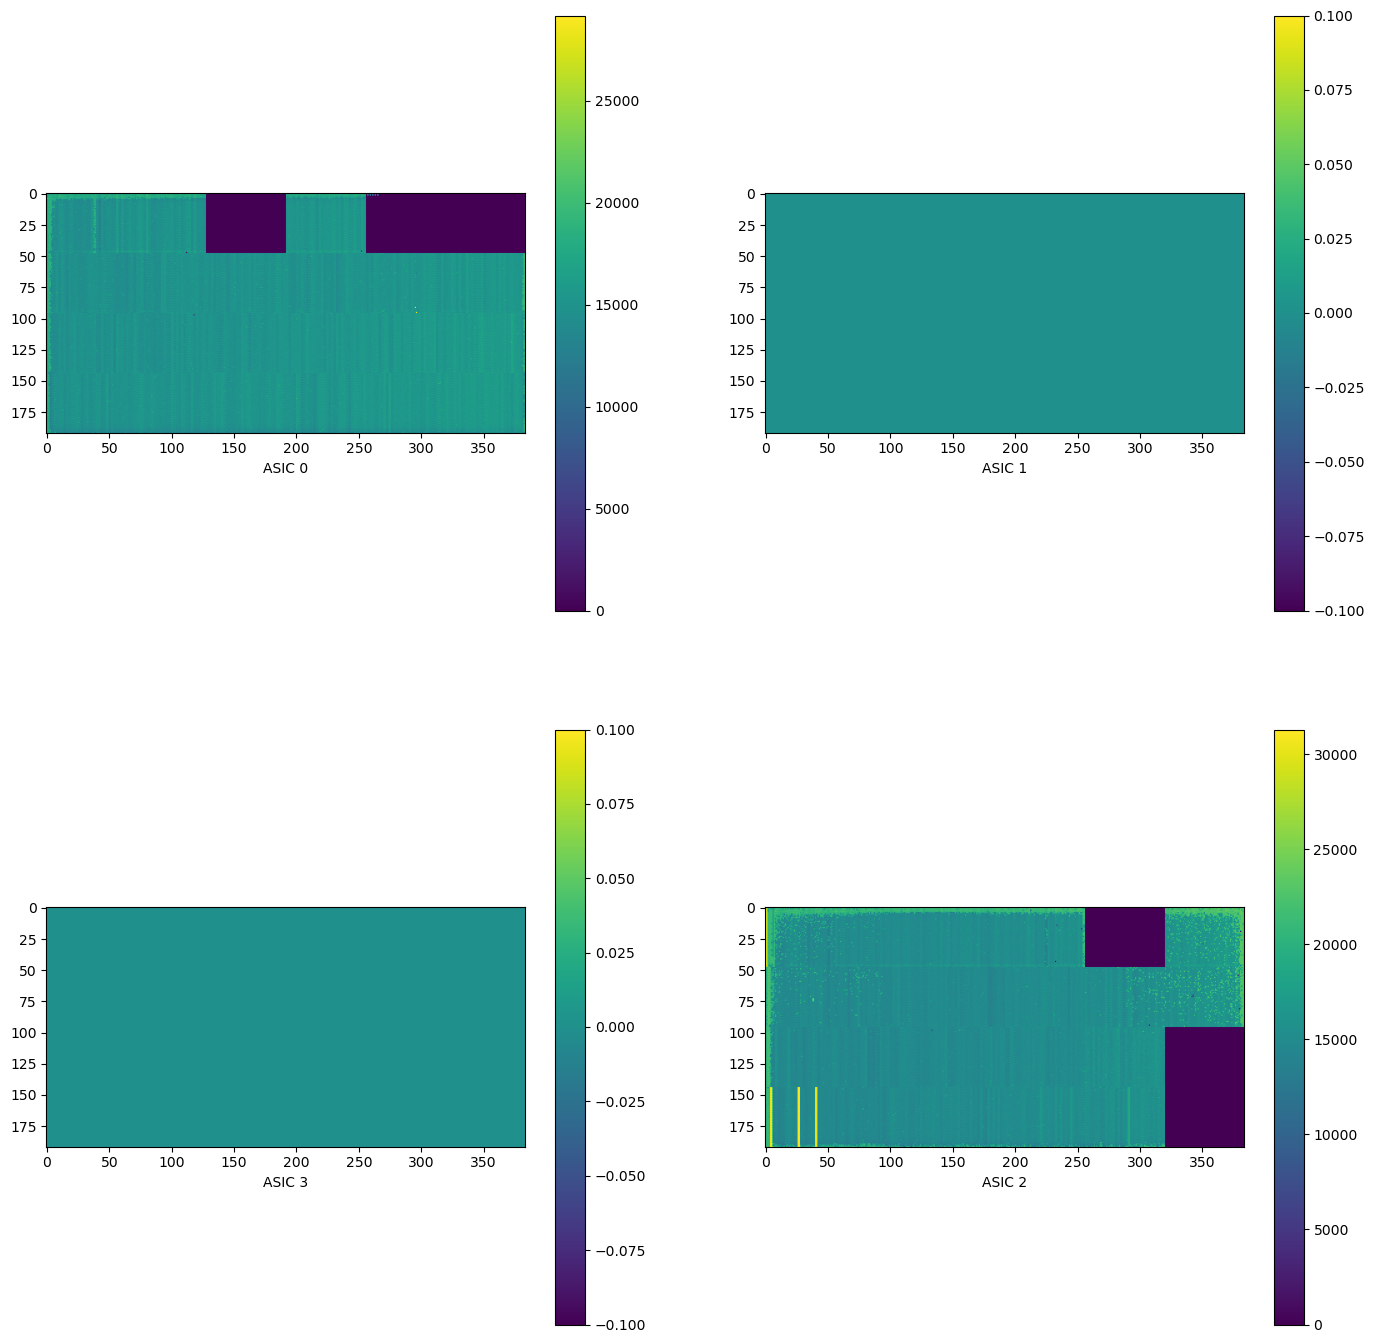

In [12]:
plotReceiverFrames()

# Manipulate ASIC registers

In [ ]:
#Manipulate ASIC register
for asicIndex in range(root.numOfAsics) : 
    root.App.Mv2Asic[asicIndex].enable.set(True)
    root.App.Mv2Asic[asicIndex].mTest.set(True)
    root.App.Mv2Asic[asicIndex].mTest.set(False)

ASIC3.mTest.set(False)

In [ ]:
#Clean up
root.enableDataRcv(False)
root.disableAndCleanAllFullRateDataRcv()
root.enableDataDebug(False)

# Full acquisition of descrambled data in numpy array example

In [14]:
# Perform descrambled acquisition using debug class without writing to file. Has awesome descrambling performance
root.enableAllAsics(False)
root.enableAsic(2, True)
DEBUG2.enableDataDebug(True)
DEBUG2.cleanData()

frames = 100
rate = 100

root.hwTrigger(frames, rate)

# Although the triggers above may have finished, descrambling takes time
while ( frames != DEBUG2.getData().shape[2]) :
    time.sleep(1)
    print("Descrambled {}".format(DEBUG2.getData().shape[2]), end='\r')
print("Data Descrambled")
print(DEBUG2.getData().shape)

Stop Triggers command executed
Set Auto Trigger command executed
Start Auto Trigger command executed
ASIC:2 F#:72511 Mask:0xc10200
Triggers sent: 100
Stop Triggers command executed
Data Descrambled
(192, 384, 100)


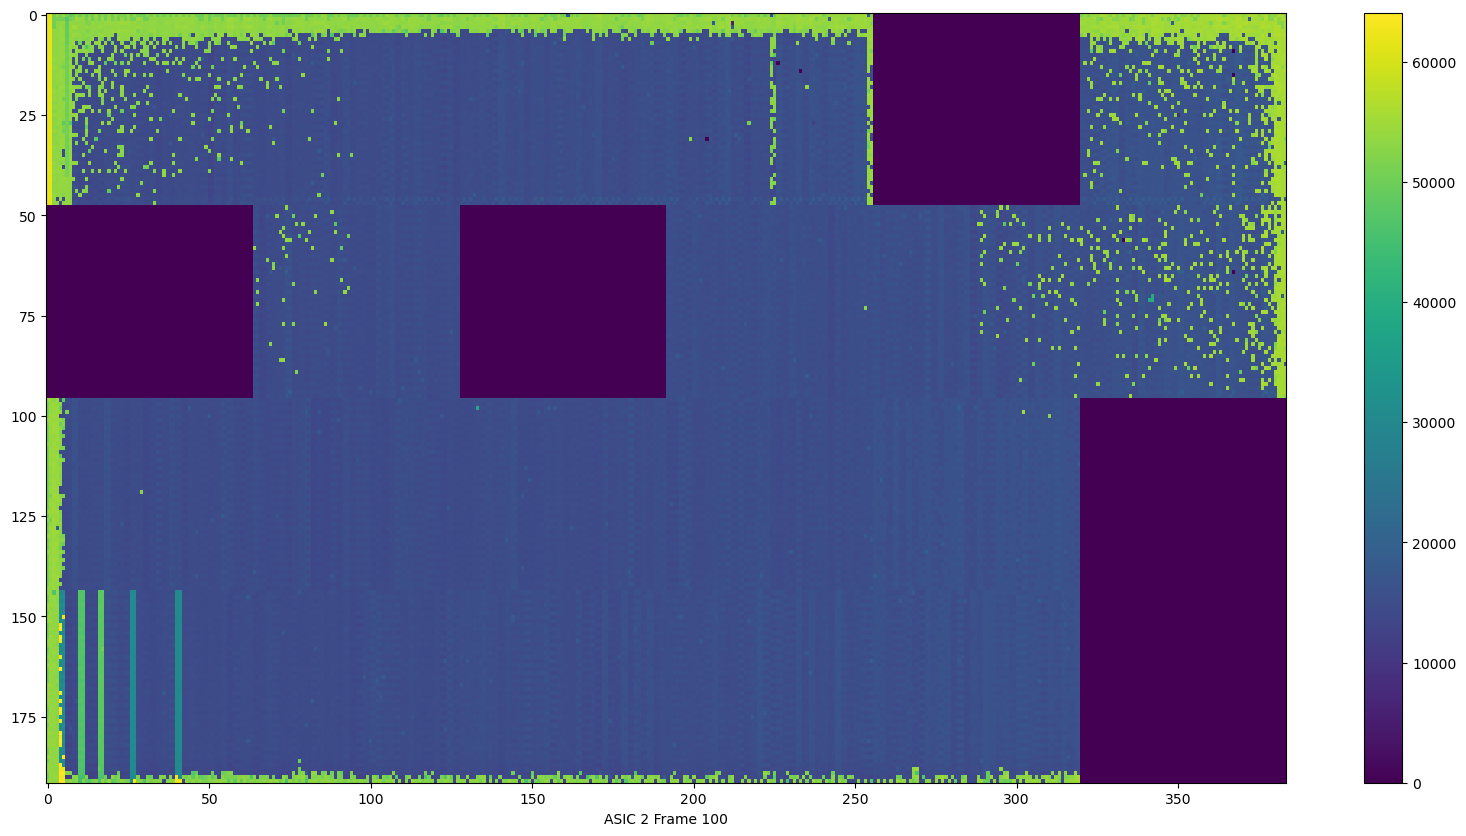

In [15]:
#Display image. Note that Interpolation is enabled. That is similar to auto contrast
plt.figure(figsize = (20,10))
plt.imshow(DEBUG2.getData()[:,:,99], interpolation='nearest', aspect='auto')
plt.xlabel("ASIC 2 Frame 100")
plt.colorbar()

In [16]:
# Disable data debug so it does not store data infinitely and crash software
DEBUG2.cleanData()
print(DEBUG2.getData().shape)
DEBUG2.enableDataDebug(False)

(192, 384, 0)


# Using fullRateReceiver class for acquisition with dark application

In [17]:
# Full rate reciever is slower than debug class, but it provides extra processing like applying dark
root.enableFullRateDataRcv(2, True)
root.enableAllAsics(False)
root.enableAsic(2, True)
FULLRATERCV2.cleanData()

In [18]:
# apply dark to next image
FULLRATERCV2.ApplyDark.set(False)
FULLRATERCV2.DarkReady.set(False)
FULLRATERCV2.NumDarkReq.set(1)
FULLRATERCV2.CollectDark.set(True)
while (FULLRATERCV2.DarkReady.get() == False) :
    root.Trigger()
    time.sleep(1)
FULLRATERCV2.ApplyDark.set(True)


ASIC:2 F#:72611 Mask:0xc10000
ASIC:2 F#:72611 Mask:0xc10000
ASIC:2 F#:72612 Mask:0xc10000
ASIC:2 F#:72612 Mask:0xc10000

*****Dark ready*****



In [19]:
FULLRATERCV2.cleanData()

#run some triggers and exercise lanes and locks
frames = 100
rate = 1000

root.hwTrigger(frames, rate)

# Although the triggers above may have finished, descrambling takes time
prev = curr = 0
while ( frames != FULLRATERCV2.getData().shape[2]) :
    time.sleep(0.1)
    curr = FULLRATERCV2.getData().shape[2]
    print("Descrambled {} at rate {:.1f} FPS                 ".format(curr, float((curr-prev))/0.1), end='\r')
    prev = FULLRATERCV2.getData().shape[2]
print("\nData Descrambled")
print(FULLRATERCV2.getData().shape)

Stop Triggers command executed
Set Auto Trigger command executed
Start Auto Trigger command executed
ASIC:2 F#:72613 Mask:0xc10200
ASIC:2 F#:72613 Mask:0xc10200
Triggers sent: 100
Stop Triggers command executed
ASIC:2 F#:72614 Mask:0xc10200
ASIC:2 F#:72615 Mask:0xc10200
ASIC:2 F#:72616 Mask:0xc10200S                 
ASIC:2 F#:72617 Mask:0xc10200S                 
ASIC:2 F#:72618 Mask:0xc10200
ASIC:2 F#:72619 Mask:0xc10200S                 
ASIC:2 F#:72620 Mask:0xc10200S                 
ASIC:2 F#:72621 Mask:0xc10200S                 
ASIC:2 F#:72622 Mask:0xc10200S                 
ASIC:2 F#:72622 Mask:0xc10200                 
ASIC:2 F#:72623 Mask:0xc10200                 
ASIC:2 F#:72624 Mask:0xc10200PS                 
ASIC:2 F#:72625 Mask:0xc10200PS                 
ASIC:2 F#:72626 Mask:0xc10200PS                 
ASIC:2 F#:72627 Mask:0xc10200PS                 
ASIC:2 F#:72628 Mask:0xc10200PS                 
ASIC:2 F#:72629 Mask:0xc10200PS                 
ASIC:2 F#:72630 Mask:0x

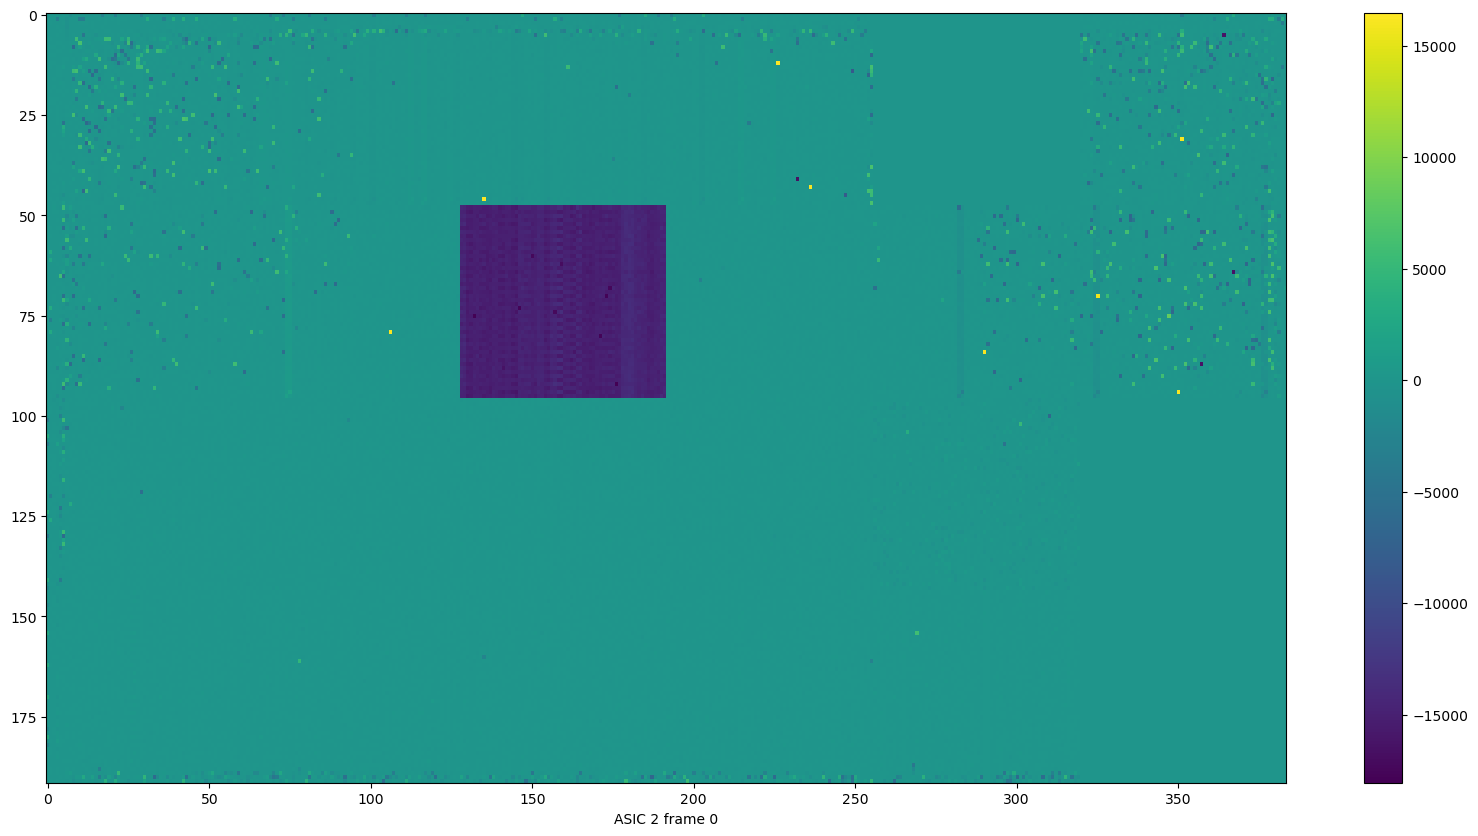

In [20]:
# Display image
plt.figure(figsize = (20,10))
plt.imshow(FULLRATERCV2.getData()[:,:,0], interpolation='nearest', aspect='auto')
plt.xlabel("ASIC 2 frame 0")
plt.colorbar()

# Charge Injection

In [4]:
# If you want to apply generated in the previous section do not run this!!!
#root.enableFullRateDataRcv(2, True)
#FULLRATERCV3.ApplyDark.set(False)

In [22]:
FULLRATERCV3.cleanData()

asicIndex = 2
chargeInjectionFirstCol = 50
chargeInjectionLastCol = 100
chargeInjectionPulserValue = 200
APP.prepareChargeInjection(asicIndex, chargeInjectionFirstCol, chargeInjectionLastCol, chargeInjectionPulserValue)
root.Trigger()

TypeError: setupChargeInjection() takes 4 positional arguments but 5 were given

In [55]:
print(FULLRATERCV2.getData().shape)

(192, 384, 453)


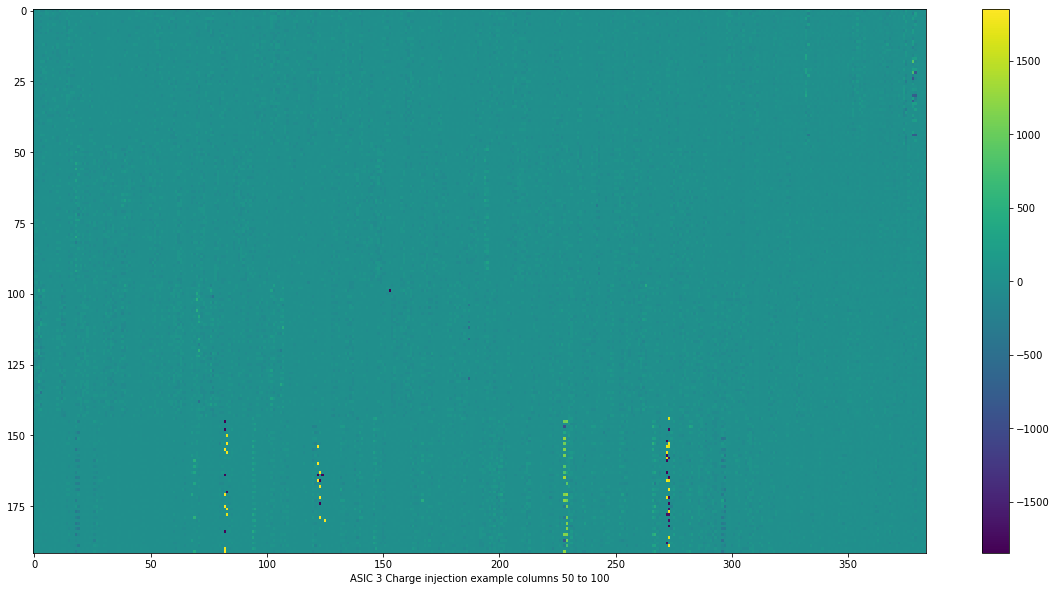

In [27]:
# Display image
plt.figure(figsize = (20,10))
plt.imshow(FULLRATERCV3.getData()[:,:,0], interpolation='nearest', aspect='auto')
plt.xlabel("ASIC 3 Charge injection example columns 50 to 100")
plt.colorbar()

In [ ]:
APP.chargeInjectionCleanup(3)

# With dark multiple frame acquisition

In [29]:
# If dark was disabled in the previous section you need to run dark again
FULLRATERCV3.cleanData()

numberOfTriggers = 100
for asicIndex in range(numberOfTriggers):
    root.Trigger()
    print("{}".format(asicIndex+1), end='\r')
    time.sleep(0.01)

In [34]:
# Run multiple times to see processed frames
np.shape(FULLRATERCV3.getData())

(192, 384, 99)

In [31]:
# Although the triggers above may have finished, descrambling takes time
while ( numberOfTriggers != FULLRATERCV3.getData().shape[2]) :
    time.sleep(0.1)
    print("Processed {}".format(FULLRATERCV3.getData().shape[2]), end='\r')
print("Data processed")
print(FULLRATERCV3.getData().shape)

KeyboardInterrupt: 

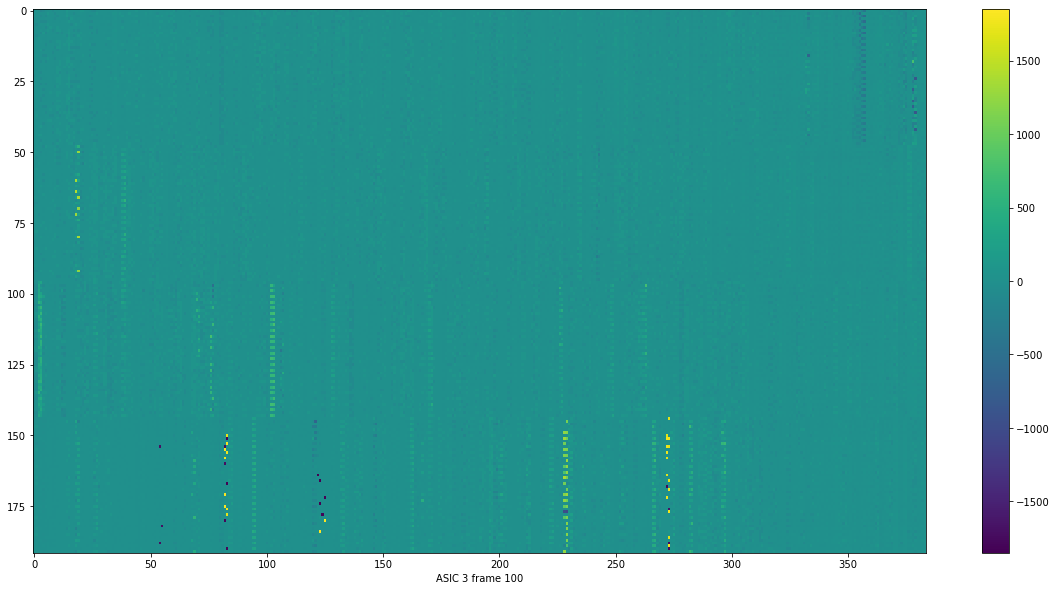

In [33]:
# Display image
plt.figure(figsize = (20,10))
plt.imshow(FULLRATERCV3.getData()[:,:,98], interpolation='nearest', aspect='auto')
plt.xlabel("ASIC 3 frame 100")
plt.colorbar()

In [39]:
# cleanup
# root.disableAndCleanAllFullRateDataRcv()

# ADC Response with external DAC waveform

In [35]:
# User ASIC 3
ASIC3.mTest.set(True)

In [36]:
first = 0x0
# min 0V, Max 2.5V
last = 1048575
step = 65535
DAC.setupFastDacWaveform(first, last, step)

In [37]:
FULLRATERCV3.cleanData()

#run some triggers and exercise lanes and locks
frames = 16
rate = 2
root.hwTrigger(frames, rate)

Stop Triggers command executed
Set Auto Trigger command executed
Start Auto Trigger command executed
Triggers sent: 16
Stop Triggers command executed


In [38]:
# Although the triggers above may have finished, descrambling takes time
while ( frames != FULLRATERCV3.getData().shape[2]) :
    time.sleep(0.1)
    print("Processed {}".format(FULLRATERCV3.getData().shape[2]), end='\r')
print("Data processed")
print(FULLRATERCV3.getData().shape)

Data processed
(192, 384, 16)


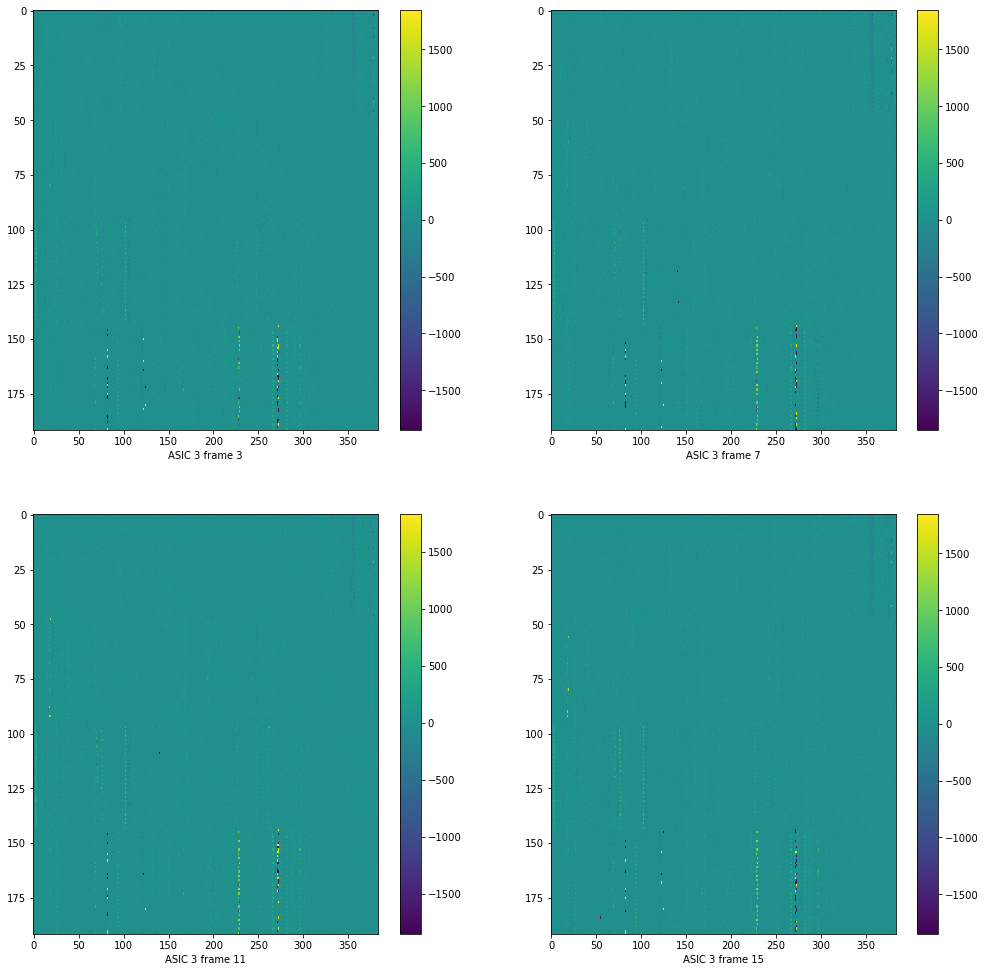

In [39]:
#plot images
plt.subplots(2,2,figsize=(17,17))
for imageIndex in range(4):
    plt.subplot(2,2,imageIndex+1)
     
    plt.imshow(FULLRATERCV3.getData()[:,:,imageIndex * 4 + 3], interpolation='nearest', aspect='auto')
    plt.xlabel("ASIC 3 frame {}".format(imageIndex * 4 + 3))
    plt.colorbar()

In [40]:
DAC.cleanupFastDacWaveform()
ASIC3.mTest.set(False)

# Laser with all four ASICs

In [4]:
#ASIC2 FIX?
ASIC2.pipoclk_delay_row0.set(0x7)
ASIC2.pipoclk_delay_row1.set(0x8)
ASIC2.pipoclk_delay_row2.set(0x8)
ASIC2.pipoclk_delay_row3.set(0x8)

In [5]:
# Full rate reciever is slower than debug class, but it provides extra processing like applying dark
root.disableAndCleanAllFullRateDataRcv()
root.enableDataRcv(False)
root.enableDataDebug(False)
root.enableFullRateDataRcv(3, True)
root.enableFullRateDataRcv(2, True)
root.enableFullRateDataRcv(1, True)
root.enableFullRateDataRcv(0, True)
root.enableAllAsics(True)

# apply dark to next image
FULLRATERCV3.ApplyDark.set(False)
FULLRATERCV3.DarkReady.set(False)
FULLRATERCV3.NumDarkReq.set(1)
FULLRATERCV3.CollectDark.set(True)
while (FULLRATERCV3.DarkReady.get() == False) :
    root.Trigger()
    time.sleep(1)
FULLRATERCV3.ApplyDark.set(True)

# apply dark to next image
FULLRATERCV2.ApplyDark.set(False)
FULLRATERCV2.DarkReady.set(False)
FULLRATERCV2.NumDarkReq.set(1)
FULLRATERCV2.CollectDark.set(True)
while (FULLRATERCV2.DarkReady.get() == False) :
    root.Trigger()
    time.sleep(1)
FULLRATERCV2.ApplyDark.set(True)

# apply dark to next image
FULLRATERCV1.ApplyDark.set(False)
FULLRATERCV1.DarkReady.set(False)
FULLRATERCV1.NumDarkReq.set(1)
FULLRATERCV1.CollectDark.set(True)
while (FULLRATERCV1.DarkReady.get() == False) :
    root.Trigger()
    time.sleep(1)
FULLRATERCV1.ApplyDark.set(True)

# apply dark to next image
FULLRATERCV0.ApplyDark.set(False)
FULLRATERCV0.DarkReady.set(False)
FULLRATERCV0.NumDarkReq.set(1)
FULLRATERCV0.CollectDark.set(True)
while (FULLRATERCV0.DarkReady.get() == False) :
    root.Trigger()
    time.sleep(1)
FULLRATERCV0.ApplyDark.set(True)


*****Dark ready*****


*****Dark ready*****


*****Dark ready*****


*****Dark ready*****



In [52]:
FULLRATERCV3.cleanData()
FULLRATERCV2.cleanData()
FULLRATERCV1.cleanData()
FULLRATERCV0.cleanData()


#run some triggers and exercise lanes and locks
root.Trigger()

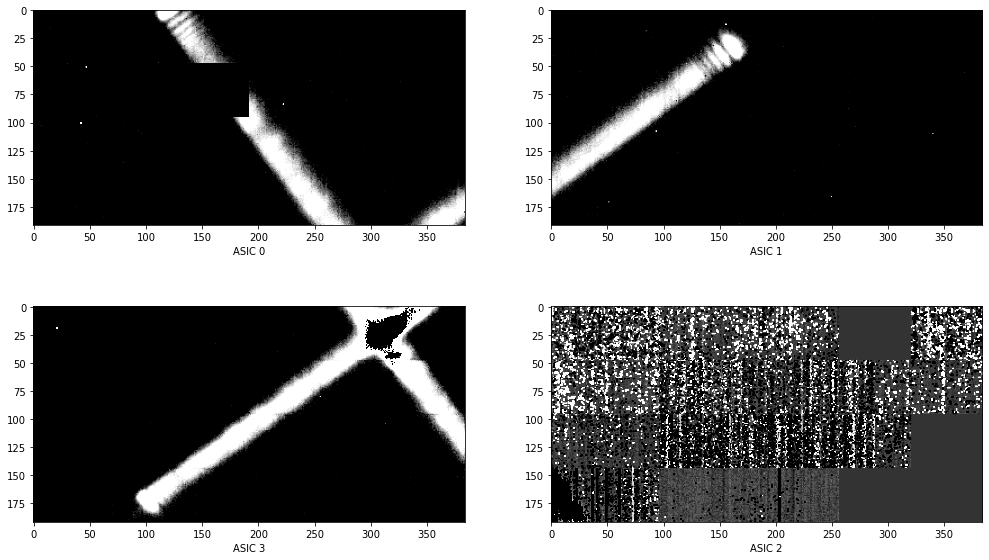

In [54]:
# Display images

plt.subplots(2,2,figsize=(17,10))
for asicIndex in range(root.numOfAsics):
    if asicIndex == 3 :
        plt.subplot(2,2,3)
        plt.imshow(FULLRATERCV3.getData()[:,:,0], cmap='Greys',  vmax = -100, vmin = -500)
        plt.xlabel("ASIC 3")
    elif asicIndex == 2 :
        plt.subplot(2,2,4)
        plt.imshow(FULLRATERCV2.getData()[:,:,0], cmap='Greys',  vmax = 100, vmin = -500)
        plt.xlabel("ASIC 2")
    elif asicIndex == 1 :
        plt.subplot(2,2,asicIndex+1)
        plt.imshow(np.rot90(FULLRATERCV1.getData()[:,:,0],2), cmap='Greys',  vmax = -100, vmin = -500)
        plt.xlabel("ASIC 1")
    else :
        plt.subplot(2,2,asicIndex+1)
        plt.imshow(np.rot90(FULLRATERCV0.getData()[:,:,0],2), cmap='Greys',  vmax = -100, vmin = -500)
        plt.xlabel("ASIC 0")

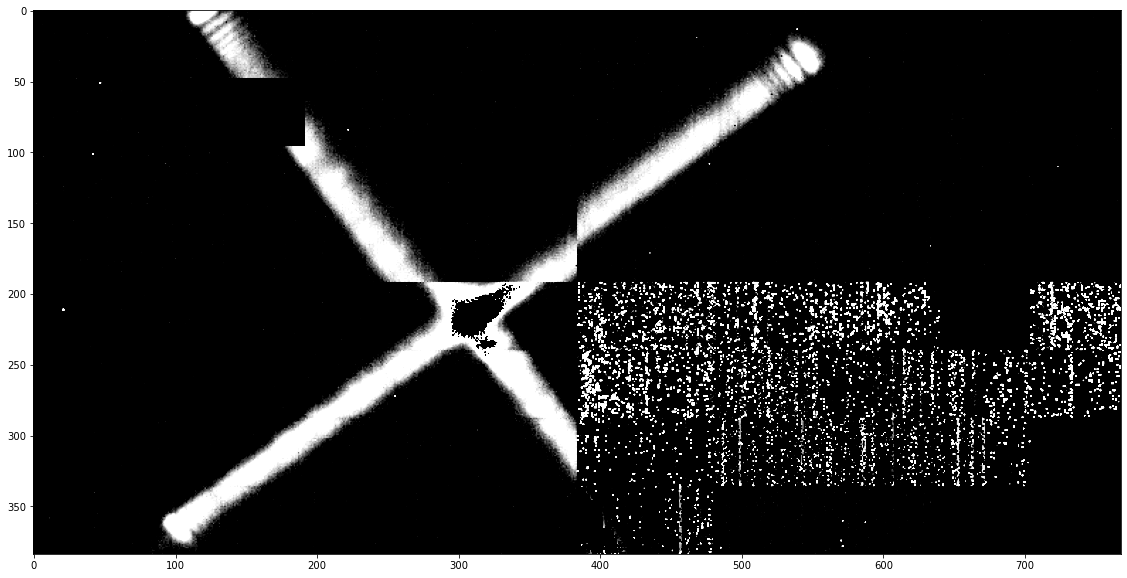

In [58]:
#plot all images together

firstRow  = np.concatenate((np.rot90(FULLRATERCV0.getData()[:,:,0],2), np.rot90(FULLRATERCV1.getData()[:,:,0],2)), axis=1)
lastRow   = np.concatenate((FULLRATERCV3.getData()[:,:,0], FULLRATERCV2.getData()[:,:,0]), axis=1)
fullImage = np.concatenate((firstRow, lastRow), axis=0)

plt.figure(figsize = (20,10))
plt.imshow(fullImage, cmap='Greys',  vmax = -100, vmin = -500)

In [63]:
np.save("/afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/Dawood", fullImage)

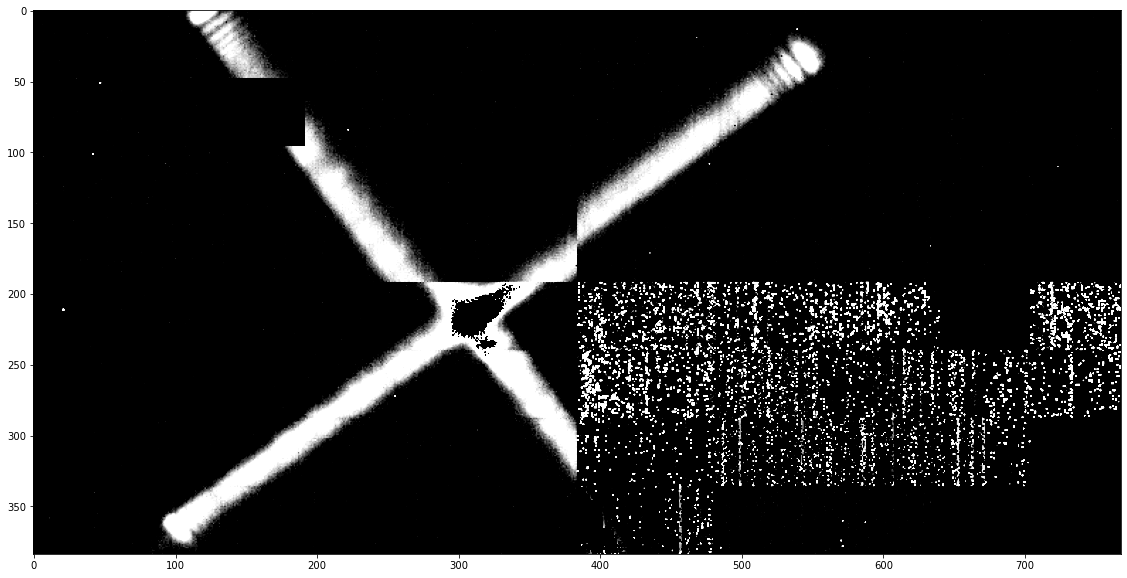

In [2]:
x = np.load("/afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/image.npy")
plt.figure(figsize = (20,10))
plt.imshow(x, cmap='Greys',  vmax = -100, vmin = -500)

In [24]:
x[192:,384:] = 0
inserted = x
for i in range(20):
    inserted = np.insert(inserted, 192, 0, axis=0)

for i in range(20):
    inserted = np.insert(inserted, 384, 0, axis=1)

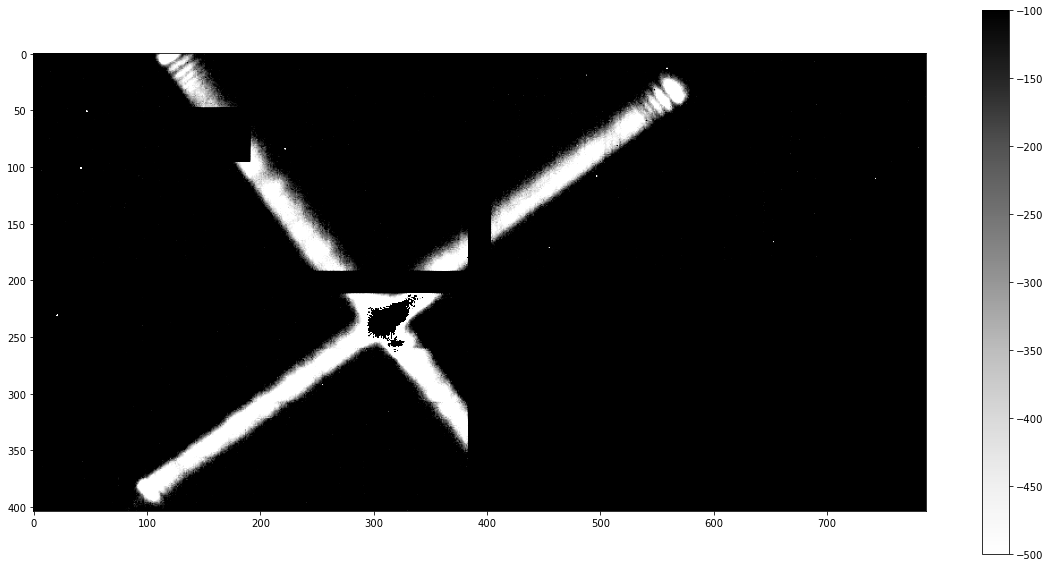

In [34]:
plt.figure(figsize = (20,10))
plt.imshow(inserted, cmap='Greys',  vmax = -100, vmin = -500)
plt.colorbar()

# ADC Response with external DAC single writes

In [41]:
# User ASIC 3
DAC.cleanupFastDacWaveform()
FULLRATERCV3.cleanData()
ASIC3.mTest.set(True)

In [42]:
#write to DAC
value = 0xfffff
DAC.FastDac.DacValue.set(value)
print("Fast DAC set to {}V".format(DAC.FastDac.DacValueV.get()))

Fast DAC set to 2.500V


In [50]:
root.Trigger()

In [51]:
print(FULLRATERCV3.getData().shape)

(192, 384, 1)


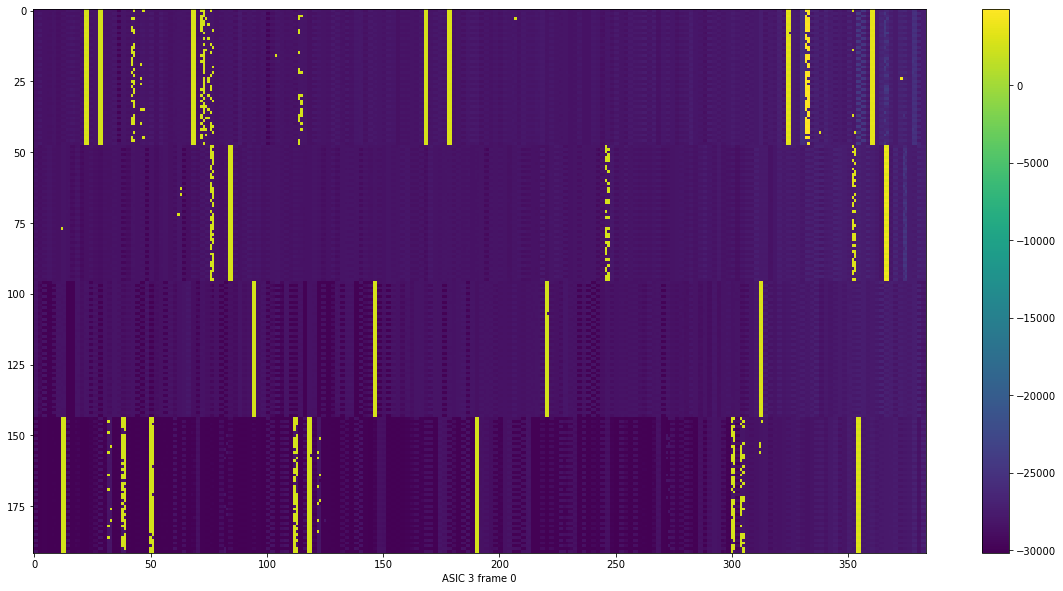

In [52]:
# Display image
plt.figure(figsize = (20,10))
plt.imshow(FULLRATERCV3.getData()[:,:,0], interpolation='nearest', aspect='auto')
plt.xlabel("ASIC 3 frame 0")
plt.colorbar()

# Keithley Readings

In [54]:
# Get Keithley voltage and current
print("Keithley voltage set to {}".format(getKeithleyVoltage()))

for i in range(10):
    print("Consumed current is: {}".format(getKeithleyCurrent()))
    time.sleep(1)

Keithley voltage set to -21.0
Consumed current is: -8.270824e-07
Consumed current is: -8.26473e-07
Consumed current is: -8.26473e-07
Consumed current is: -8.253609e-07
Consumed current is: -8.248513e-07
Consumed current is: -8.244324e-07
Consumed current is: -8.240092e-07
Consumed current is: -8.240092e-07
Consumed current is: -8.231624e-07
Consumed current is: -8.228303e-07


In [16]:
# Increment Keithley voltage
incrementKeithleyVoltage()
time.sleep(5) # voltage is scanned from hardware every 5 seconds
getKeithleyVoltage()

-20.0

In [17]:
# Decrement Keithley voltage
decrementKeithleyVoltage()
time.sleep(5)
getKeithleyVoltage()

-21.0

# Control waveform delays

In [37]:
Width = 5
Delay = 10
setSR0(Width, Delay)
setAcq1(Width, Delay)
setAcq2(Width, Delay)
setR0(Width, Delay)
setSync(Width, Delay)

SR0 Width set to 0.030uS
SR0 Delay set to 0.060uS
Acq1 Width set to 0.032uS
Acq1 Delay set to 0.064uS
Acq2 Width set to 0.032uS
Acq2 Delay set to 0.064uS
R0 Width set to 0.032uS
R0 Delay set to 0.064uS
Sync Delay set to 0.060uS


# Writing data to a rogue format file on full rate

In [3]:
root.enableDataRcv(False)
root.disableAndCleanAllFullRateDataRcv()
root.enableAllAsics(False)
root.enableDataDebug(False)

root.enableAsic(3, True)

ssdPath = "/u1/ePixHRM320k/acquisition"
filename = f"{ssdPath}/test.dat"
rate = 5000 # HZ
frames = 70000

root.acquireToFile(filename, frames, rate)

Acquisition started: filename: /u1/ePixHRM320k/acquisition/test.dat, rate: 5000, #frames:1000
Stop Triggers command executed
Set Auto Trigger command executed
Start Auto Trigger command executed
Triggers sent: 1000
Stop Triggers command executed
Received on channel 0 0 frames...
Received on channel 1 0 frames...
Received on channel 2 0 frames...
Received on channel 3 1000 frames...
Waiting for file to close...
Acquisition complete and file closed


# Reading data from a rogue format file

In [5]:
# Has good performance
  
ssdPath = "/u1/ePixHRM320k/acquisition"
filename = f"{ssdPath}/test.dat"

root.readFromFile(filename)

In [6]:
np.shape(root.readerReceiver.getData())

(192, 384, 1000)

# Convert to HDF5

In [3]:
"""
CONVERT: DAT TO HDF5
"""
ssdPath = "/u1/ePixHRM320k/acquisition"
filename = f"{ssdPath}/test.dat"

# --- FAST MULTI-CORE METHOD --- #
# Note: For 130k frames at x20 cores, takes ~1.5 hours
DAT_to_HDF5 = '{}/imgProc/read_image_from_file_ePixMHrv2.py'.format(rootTopLevel)
print('Waiting... runing in process... when * changes to a number then done')
%run {DAT_to_HDF5} {filename} {"--cores=100 --help"}
print("HDF5 generation complete")

Waiting... runing in process... when * changes to a number then done
Starting to get data set 0
Read 1000 frames
Camera  ePixHrMv2  selected.
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 1
Read 1000 frames
Camera  ePixHrMv2  selected.
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 2


KeyboardInterrupt: 

HDF5 generation complete


# Trigger generator

In [20]:
triggerGeneratorAcquire(100, [DEBUG1, DEBUG2], [1,2]) 